# Extract an arbitrary line from a 3D volume

Arbitrary lines are often defined as peicewise lines on time/z slices or basemap views that draw a path through features of interest or for example betweem well locations.

By extracting an arbitrary line we hope to end up with a uniformly sampled vertical section of data that traverses the path where the sampling interval is. of the order of the bin interval of the dataset



In [1]:
%load_ext autoreload
%autoreload 2

from os import path
import numpy as np
import matplotlib.pyplot as plt

## Load Small 3D Volume from Volve

In [2]:
volve_3d_path = path.join("..", "data", "volve10r12-full-twt-sub3d.sgy")
print(f"{volve_3d_path} exists: {path.exists(volve_3d_path)}")

../data/volve10r12-full-twt-sub3d.sgy exists: True


In [3]:
from segysak.segy import segy_loader, get_segy_texthead, segy_header_scan, segy_header_scrape, well_known_byte_locs

volve_3d = segy_loader(volve_3d_path, **well_known_byte_locs("petrel_3d"))

/Users/stevejpurves/dev/swung/segysak/segysak/segy/_segy_headers.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



Loading as 3D
Fast direction is CDP


## Arbitrary Lines

We define a line by as lists of cdp_x & cdp_y points. These can be inside or outside of the survey, but oviously should intersect it in order to be useful.

In [4]:
arb_line_A = (np.array([434300, 434600, 435500, 436300]), np.array([6.4786e6, 6.4780e6, 6.4779e6, 6.4781e6]))
arb_line_B = (np.array([434000, 434600, 435500, 436500]), np.array([6.4786e6, 6.4776e6, 6.4786e6, 6.4775e6]))

Let's see how these lines are placed relative to the survey bounds. We can see *A* is full enclosed whilst *B* has some segments outside.

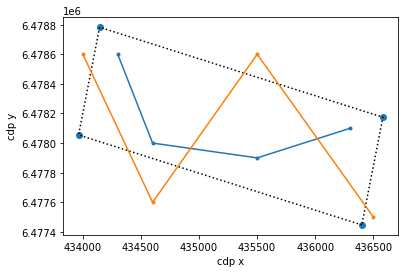

In [5]:
ax = volve_3d.seis.plot_bounds()
ax.plot(arb_line_A[0], arb_line_A[1], '.-')
ax.plot(arb_line_B[0], arb_line_B[1], '.-')

Let's extract line A. 

We specify a `bin_spacing_hint` which is our desired bin spacing along the line. The function use this hint to calculate the closest binspacing that maintains uniform sampling.

We have also specified the `method='linear'`, this is the default but you can specify and method that `DataArray.interp` accepts

In [9]:
from time import time

tic = time()
line_A = volve_3d.seis.interp_line(arb_line_A[0], arb_line_A[1], bin_spacing_hint=10)
toc = time()
print(f"That took {toc-tic} seconds")

That took 27.485507249832153 seconds


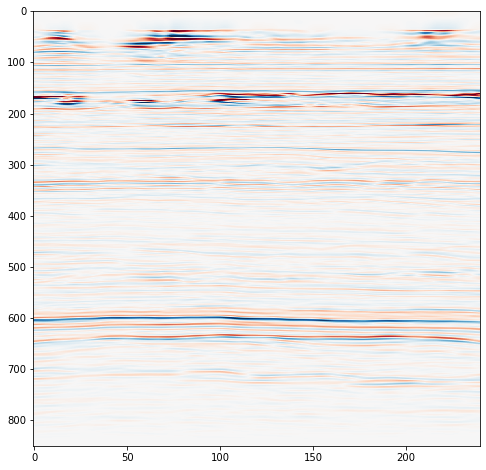

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(line_A.to_array().squeeze().T, aspect="auto", cmap="RdBu", vmin=-10, vmax=10)

In [12]:
tic = time()
line_B = volve_3d.seis.interp_line(arb_line_B[0], arb_line_B[1], bin_spacing_hint=10)
toc = time()
print(f"That took {toc-tic} seconds")

That took 27.14954400062561 seconds


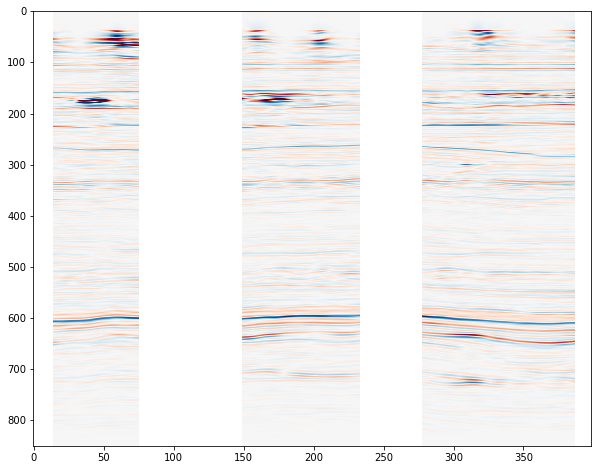

In [13]:
plt.figure(figsize=(10,8))
plt.imshow(line_B.to_array().squeeze().T, aspect="auto", cmap="RdBu", vmin=-10, vmax=10)

## Petrel Shapefile

We have an arbitrary line geometry defined over this small survey region stored in a shape file exported from Petrel. 

Let's load that and extract an arbirary line using segysak. We also have the seismic data extracted along that line by Petrel, so we can see how that compares.

In [14]:
import shapefile
from pprint import pprint

Load the shapefile and get the list of points

In [15]:
sf = shapefile.Reader(path.join("..","data","arbitrary_line.shp"))
line_petrel = sf.shapes() 
print(f"shapes are type {sf.shapeType} == POLYLINEZ")
print(f"There are {len(sf.shapes())} shapes in here")
print(f"The line has {len(sf.shape(0).points)} points")

points_from_shapefile = [list(t) for t in list(zip(*sf.shape(0).points))]
pprint(points_from_shapefile)

shapes are type 13 == POLYLINEZ
There are 1 shapes in here
The line has 10 points
[[434244.1111175297,
  434285.5847503422,
  434588.36941831093,
  434885.0338465618,
  435036.1407475077,
  435239.3142425297,
  435544.93789816764,
  435714.1388649335,
  435772.37332456093,
  436308.21023862343],
 [6478575.031033052,
  6478218.093533052,
  6477971.34255649,
  6477874.469884046,
  6477991.699391355,
  6478202.953884615,
  6478214.490538706,
  6478065.665258892,
  6477687.288845552,
  6477563.074001802]]


Load the segy containing the line thst Petrel exracted along this geometry

In [16]:
line_extracted_by_petrel_path = path.join("..", "data", "volve10r12-full-twt-arb.sgy")
print(f"{line_extracted_by_petrel_path} exists: {path.exists(line_extracted_by_petrel_path)}")
line_extracted_by_petrel = segy_loader(line_extracted_by_petrel_path, **well_known_byte_locs("petrel_3d"))

../data/volve10r12-full-twt-arb.sgy exists: True



Loading as 3D
Fast direction is TRACE_SEQUENCE_FILE


Extract the line using segysak

In [17]:
tic = time()
line_extracted_by_segysak = volve_3d.seis.interp_line(*points_from_shapefile,
                                        bin_spacing_hint=10,
                                        line_method='linear',
                                        xysel_method='linear')
toc = time()
print(f"That took {toc-tic} seconds")

That took 30.934829711914062 seconds


Plot the extract lines side by side

Text(0.5, 1.0, 'petrel')

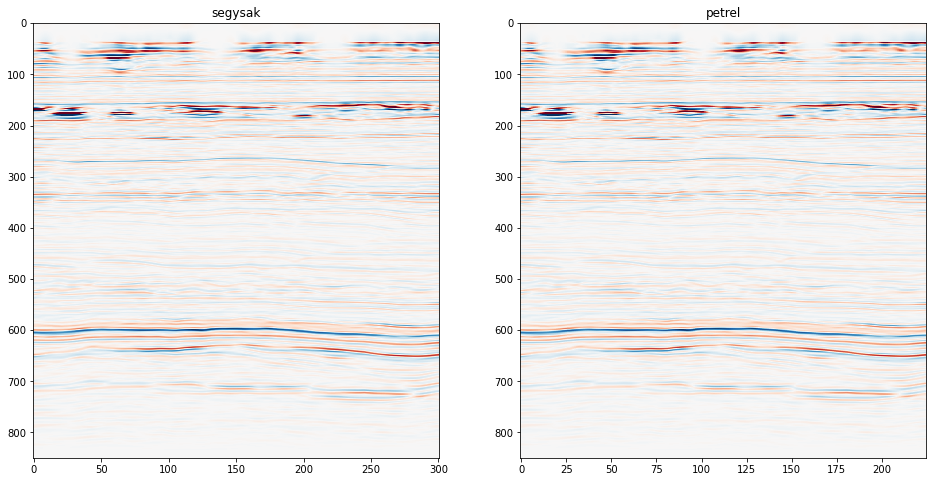

In [18]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].imshow(line_extracted_by_segysak.to_array().squeeze().T, aspect="auto", cmap="RdBu", vmin=-10, vmax=10)
axs[0].set_title("segysak")
axs[1].imshow(line_extracted_by_petrel.to_array().squeeze().T, aspect="auto", cmap="RdBu", vmin=-10, vmax=10)
axs[1].set_title("petrel")

Plot the geometry, trace header locatons along with the volve 3d bound box, tmo make sure things line up

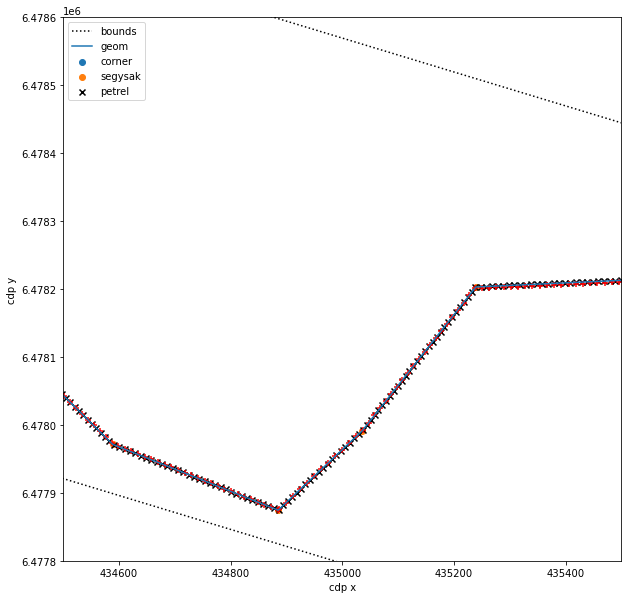

In [19]:
plt.figure(figsize=(10,10))
ax = volve_3d.seis.plot_bounds(ax=plt.gca())

# plot path
ax.plot(*points_from_shapefile)
ax.scatter(*points_from_shapefile)

# plot trace positons from extracted lines based on header
ax.scatter(line_extracted_by_segysak.cdp_x, line_extracted_by_segysak.cdp_y, marker='x', color='k')
ax.scatter(line_extracted_by_petrel.cdp_x, line_extracted_by_petrel.cdp_y, marker='+', color='r')

ax.set_xlim(434500,435500)
ax.set_ylim(6477800, 6478600)
plt.legend(labels=['bounds','geom','corner','segysak','petrel'])